In [8]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterstats as rs
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gdf = gpd.read_file('../temp/kota_pontianak_smeru_fiat.shp')

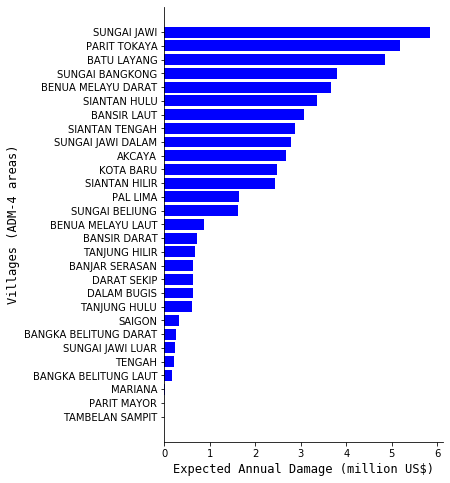

In [3]:
gdf.sort_values('baseEAD', ascending=False, inplace=True)
gdf.reset_index(drop=True, inplace=True)

# colors = ['blue']*(len(feature_names)-4) + ['red']*4
colors = 'blue'

fig, ax = plt.subplots(figsize=(5,8))
ax.barh(range(len(gdf)), [x/1e6 for x in reversed(list(gdf.baseEAD))], align='center', color=colors)
plt.yticks(range(len(gdf)), [x for x in reversed(list(gdf.DESA))], rotation=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Expected Annual Damage (million US$)', fontfamily='monospace', fontsize=12)
ax.set_ylabel('Villages (ADM-4 areas)', fontfamily='monospace', fontsize=12)

plt.savefig('../figs/baseEAD_2020_barchart.jpeg', dpi=300, bbox_inches='tight')

In [4]:
gdf['baseEAD_cumsum'] = gdf['baseEAD'].cumsum()
gdf['baseEAD_cumsum'] = gdf['baseEAD_cumsum'] / gdf['baseEAD'].sum()

gdf.loc[gdf['baseEAD_cumsum']<0.85][['DESA', 'baseEAD_cumsum', 'baseEAD']]

,DESA,baseEAD_cumsum,baseEAD
0,SUNGAI JAWI,0.111789,5.841443e+06
1,PARIT TOKAYA,0.210992,5.183770e+06
2,BATU LAYANG,0.303805,4.849877e+06
3,SUNGAI BANGKONG,0.376579,3.802732e+06
4,BENUA MELAYU DARAT,0.446700,3.664119e+06
5,SIANTAN HULU,0.511063,3.363242e+06
6,BANSIR LAUT,0.569670,3.062494e+06
7,SIANTAN TENGAH,0.624712,2.876153e+06
8,SUNGAI JAWI DALAM,0.678170,2.793440e+06
9,AKCAYA,0.729483,2.681283e+06


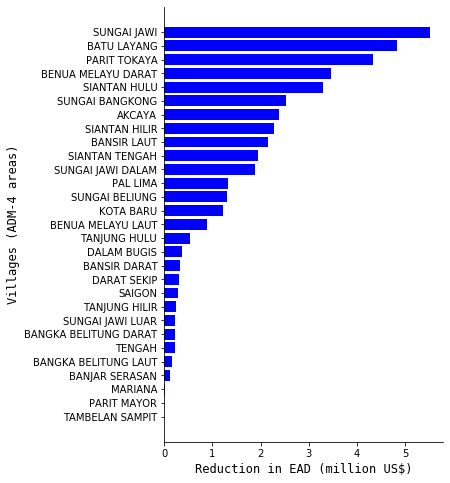

In [5]:
gdf.sort_values('benefit', ascending=False, inplace=True)
gdf.reset_index(drop=True, inplace=True)

# colors = ['blue']*(len(feature_names)-4) + ['red']*4
colors = 'blue'

fig, ax = plt.subplots(figsize=(5,8))
ax.barh(range(len(gdf)), [x/1e6 for x in reversed(list(gdf.benefit))], align='center', color=colors)
plt.yticks(range(len(gdf)), [x for x in reversed(list(gdf.DESA))], rotation=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Reduction in EAD (million US$)', fontfamily='monospace', fontsize=12)
ax.set_ylabel('Villages (ADM-4 areas)', fontfamily='monospace', fontsize=12)

plt.savefig('../figs/benefit_2020_barchart.jpeg', dpi=300, bbox_inches='tight')

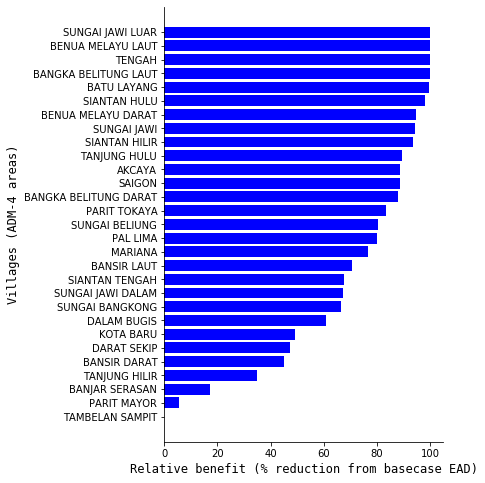

In [6]:
gdf['relative_benefit'] = gdf['benefit'] * 100 / gdf['baseEAD']
gdf['relative_benefit'].fillna(0, inplace=True)
gdf.sort_values('relative_benefit', ascending=False, inplace=True)
gdf.reset_index(drop=True, inplace=True)

# colors = ['blue']*(len(feature_names)-4) + ['red']*4
colors = 'blue'

fig, ax = plt.subplots(figsize=(5,8))
ax.barh(range(len(gdf)), [x for x in reversed(list(gdf.relative_benefit))], align='center', color=colors)
plt.yticks(range(len(gdf)), [x for x in reversed(list(gdf.DESA))], rotation=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Relative benefit (% reduction from basecase EAD)', fontfamily='monospace', fontsize=12)
ax.set_ylabel('Villages (ADM-4 areas)', fontfamily='monospace', fontsize=12)

plt.savefig('../figs/relative_benefit_2020_barchart.jpeg', dpi=300, bbox_inches='tight')

In [9]:
for var in ['baseEAD', 'measEAD', 'benefit', 'relative_benefit']:
    gdf.sort_values(var, ascending=False, inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    gdf[var+'_rank'] = gdf.index + 1
    
    gdf[var+'_rank'] = np.round(gdf[var],2)
    gdf[var+'_rank'] = gdf[var+'_rank'].rank(method='min', ascending=False)

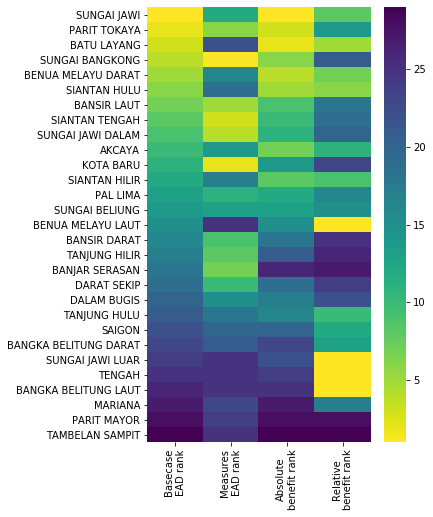

In [10]:
fig, ax = plt.subplots(figsize=(5,8))
sns.heatmap(gdf.sort_values('baseEAD', ascending=False)[['baseEAD_rank', 'measEAD_rank', 'benefit_rank', 'relative_benefit_rank']],
            cmap='viridis_r', ax=ax)

ax.set_xticklabels(['Basecase\nEAD rank', 'Measures\nEAD rank', 'Absolute\nbenefit rank', 'Relative\nbenefit rank'])

ax.set_yticklabels(gdf.sort_values('baseEAD', ascending=False)['DESA'], rotation=0)
plt.savefig('../figs/distribution_rank_2020.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
text_style = dict(horizontalalignment='right', verticalalignment='center',
                  fontsize=12, fontfamily='monospace')
markerlarge_style = dict(linestyle=':', color='0.8', markersize=12,
                    markerfacecolor="tab:blue", markeredgecolor="tab:blue")
marker_style = dict(linestyle=':', color='0.8', markersize=8,
                    markerfacecolor="tab:blue", markeredgecolor="tab:blue")
line_style = dict(linestyle=':', color='0.8', markersize=0,
                    markerfacecolor="tab:blue", markeredgecolor="tab:blue")


def format_axes(ax):
    ax.margins(0.2)
    ax.yaxis.set_visible(False)
    ax.invert_yaxis()


def split_list(a_list):
    i_half = len(a_list) // 2
    return a_list[:i_half], a_list[i_half:]

In [30]:
gdf['baseEAD_mil'] = gdf['baseEAD'] / 1e6
gdf['measEAD_mil'] = gdf['measEAD'] / 1e6

gdf.sort_values('baseEAD_mil', inplace=True, ascending=False)
gdf.reset_index(inplace=True, drop=True)

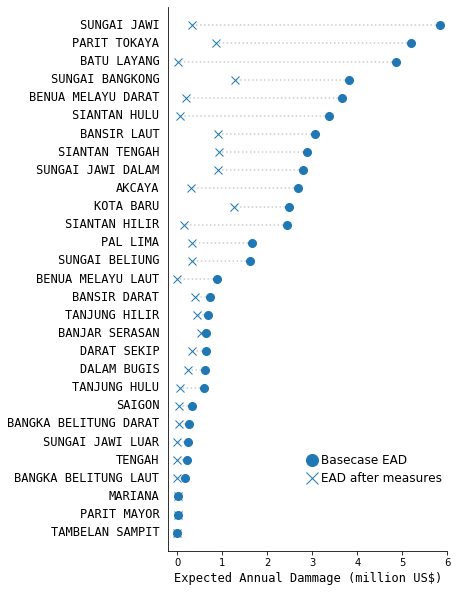

In [33]:
fig, ax = plt.subplots(figsize=(5,10))
# plt.title('Filled markers', fontsize=14)

ax.set_xlim(-0.2, np.ceil(np.max(gdf['baseEAD_mil'])))

for y, row in enumerate(gdf.iterrows()):
    
    ax.text(-0.4, y, row[1]['DESA'], **text_style)
    
    ax.plot([row[1]['baseEAD_mil'], row[1]['measEAD_mil']], [y, y], marker='.', **line_style)
    ax.plot(row[1]['baseEAD_mil'], y, marker='o', **marker_style)
    ax.plot(row[1]['measEAD_mil'], y, marker='x', **marker_style)

pos_x = 3
poso_y = 24
posx_y = 25
ax.plot(pos_x, poso_y, marker='o', **markerlarge_style)
ax.plot(pos_x, 25, marker='x', **markerlarge_style)
ax.text(pos_x+0.2, poso_y, s='Basecase EAD', fontsize=12, ha='left', va='center')
ax.text(pos_x+0.2, posx_y, s='EAD after measures', fontsize=12, ha='left', va='center')

ax.set_xlabel('Expected Annual Dammage (million US$)', fontfamily='monospace', fontsize=12)
ax.set_ylabel('Villages (ADM-4 areas)', fontfamily='monospace', fontsize=12)

ax.set_ylim(-1,len(gdf))
format_axes(ax)
sns.despine()
plt.savefig('../figs/EAD_basecase_measures_2020.jpeg', dpi=300, bbox_inches='tight')
plt.show()

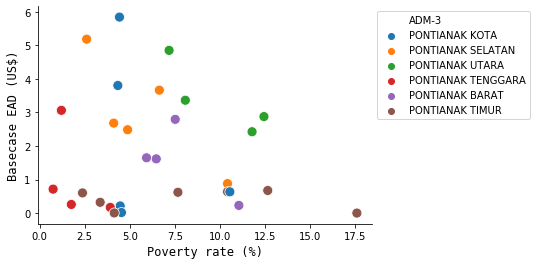

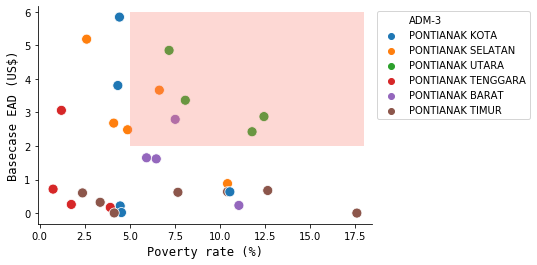

In [66]:
gdf['ADM-3']= gdf['KECAMATAN']

xvar = 'FGT0_NPL'
yvar = 'baseEAD_mil'

xlabel = 'Poverty rate (%)'
ylabel = 'Basecase EAD (US$)'

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=gdf, x=xvar, y=yvar, hue='ADM-3', ax=ax, s=100)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
ax.set_xlabel(xlabel, fontfamily='monospace', fontsize=12)
ax.set_ylabel(ylabel, fontfamily='monospace', fontsize=12)
sns.despine()
plt.savefig('../figs/{}_{}_2020.jpeg'.format(xvar, yvar), dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=gdf, x=xvar, y=yvar, hue='ADM-3', ax=ax, s=100)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
ax.set_xlabel(xlabel, fontfamily='monospace', fontsize=12)
ax.set_ylabel(ylabel, fontfamily='monospace', fontsize=12)
ax.add_patch(plt.Rectangle((5,2), 13, 4,facecolor='salmon',
                              clip_on=False,linewidth = 0, alpha=0.3))
sns.despine()
plt.savefig('../figs/{}_{}_withbox_2020.jpeg'.format(xvar, yvar), dpi=300, bbox_inches='tight')
plt.show()



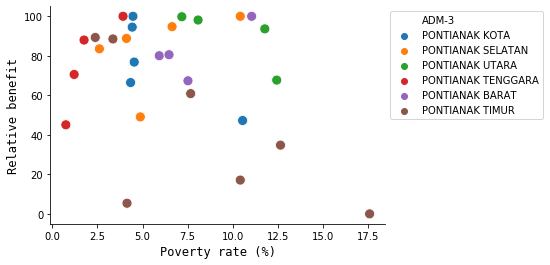

In [67]:
gdf['ADM-3']= gdf['KECAMATAN']

xvar = 'FGT0_NPL'
yvar = 'relative_benefit'

xlabel = 'Poverty rate (%)'
ylabel = 'Relative benefit'

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=gdf, x=xvar, y=yvar, hue='ADM-3', ax=ax, s=100)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
ax.set_xlabel(xlabel, fontfamily='monospace', fontsize=12)
ax.set_ylabel(ylabel, fontfamily='monospace', fontsize=12)
sns.despine()
plt.savefig('../figs/{}_{}_2020.jpeg'.format(xvar, yvar), dpi=300, bbox_inches='tight')
plt.show()

